In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette("deep")
plt.rc('font', family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus'] = False # 그래프에 마이너스 표시

# scaling
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score

# 데이터 불러오기

In [2]:
import pandas as pd
raw = pd.read_csv('clustering_data.csv')
raw.head()

,Unnamed: 0,CTY_NM,ratio,tot
0,0,강남구,117.501236,304
1,1,강동구,130.707905,201
2,2,강북구,255.741946,162
3,3,강서구,151.529412,325
4,4,관악구,232.544572,250


In [3]:
raw['CTY_NM'].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

In [4]:
df = raw.copy()

df.drop(columns='Unnamed: 0', axis=1, inplace=True)
df.rename(columns={'ratio':'노령화지수'}, inplace=True)
df.rename(columns={'tot':'접근성'}, inplace=True)
df

,CTY_NM,노령화지수,접근성
0,강남구,117.501236,304
1,강동구,130.707905,201
2,강북구,255.741946,162
3,강서구,151.529412,325
4,관악구,232.544572,250
5,광진구,164.941084,158
6,구로구,180.530203,283
7,금천구,211.962286,167
8,노원구,155.835207,375
9,도봉구,214.057018,218


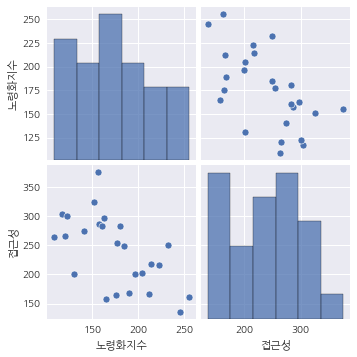

In [5]:
sns.pairplot(df)
plt.show()

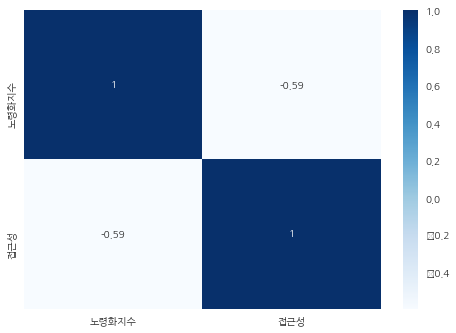

In [6]:
corr_df = df.corr(method='pearson')
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.show()
# 노령화지수, 접근성이 음의 상관관계를 갖고 있음
# 산점도와 통틀어 봤을 때 둘다 높은 군집을 구하기 어려움

# 계층적 군집분석

타공모전 수상작 참고한 코드 (scaling과 clustering을 한번에 하는 방식)

https://dacon.io/competitions/official/235758/codeshare/3180  
https://tobigs.gitbook.io/tobigs/data-analysis/undefined-3/python-2-1

* scaling 기법
1. minmax: 범위가 0~1이 되도록 함
2. standard: 평균=0, 분산=1이 되도록 함
3. roubst: 평균, 분산 대신 중간값, 사분위값을 사용

In [39]:
# Scaling Methods에 따른 Scaling 함수 생성
def df_scaler(data, cols, scale):
    df_cp = data.copy()
    
    if scale == "minmax":
        X = df_cp.loc[:,cols]
        MinMaxScalers = MinMaxScaler()
        MinMaxScalers.fit(X)
        df_MinMaxScaler = MinMaxScalers.transform(X)
        df_cp.loc[:, cols] = df_MinMaxScaler
    elif scale == "standard" :
        X = df_cp.loc[:,cols]
        StandardScalers = StandardScaler()
        StandardScalers.fit(X)
        df_StandardScalers = StandardScalers.transform(X)
        df_cp.loc[:, cols] = df_StandardScalers
    elif scale == "robust" :
        X = df_cp.loc[:,cols]
        RobustScalers = RobustScaler()
        RobustScalers.fit(X)
        df_RobustScaler = RobustScalers.transform(X)
        df_cp.loc[:, cols] = df_RobustScaler
    else:
        print("wrong")
    return df_cp

* hierarchical clustering
1. 모든 개체들 사이에 거리에 대한 유사도 행렬 계산
2. 거리가 인접한 관측치끼리 군집 형성
3. 유사도 행렬 업데이트 (반복)

* 거리에 대한 기준
1. single: 가장 가까운 개체끼리 연결
2. complete: 가장 먼 개체끼리 연결 (보수적)
3. average: 모든 점들을 모두 연결하여 평균 계산하여 가까운 데이터끼리 연결, 이상치에 덜 민감
4. centroid: 군집의 중심을 잡아 거리 계산
5. ward: 두 군집 간 제곱합 - 군집 내 제곱합의 합

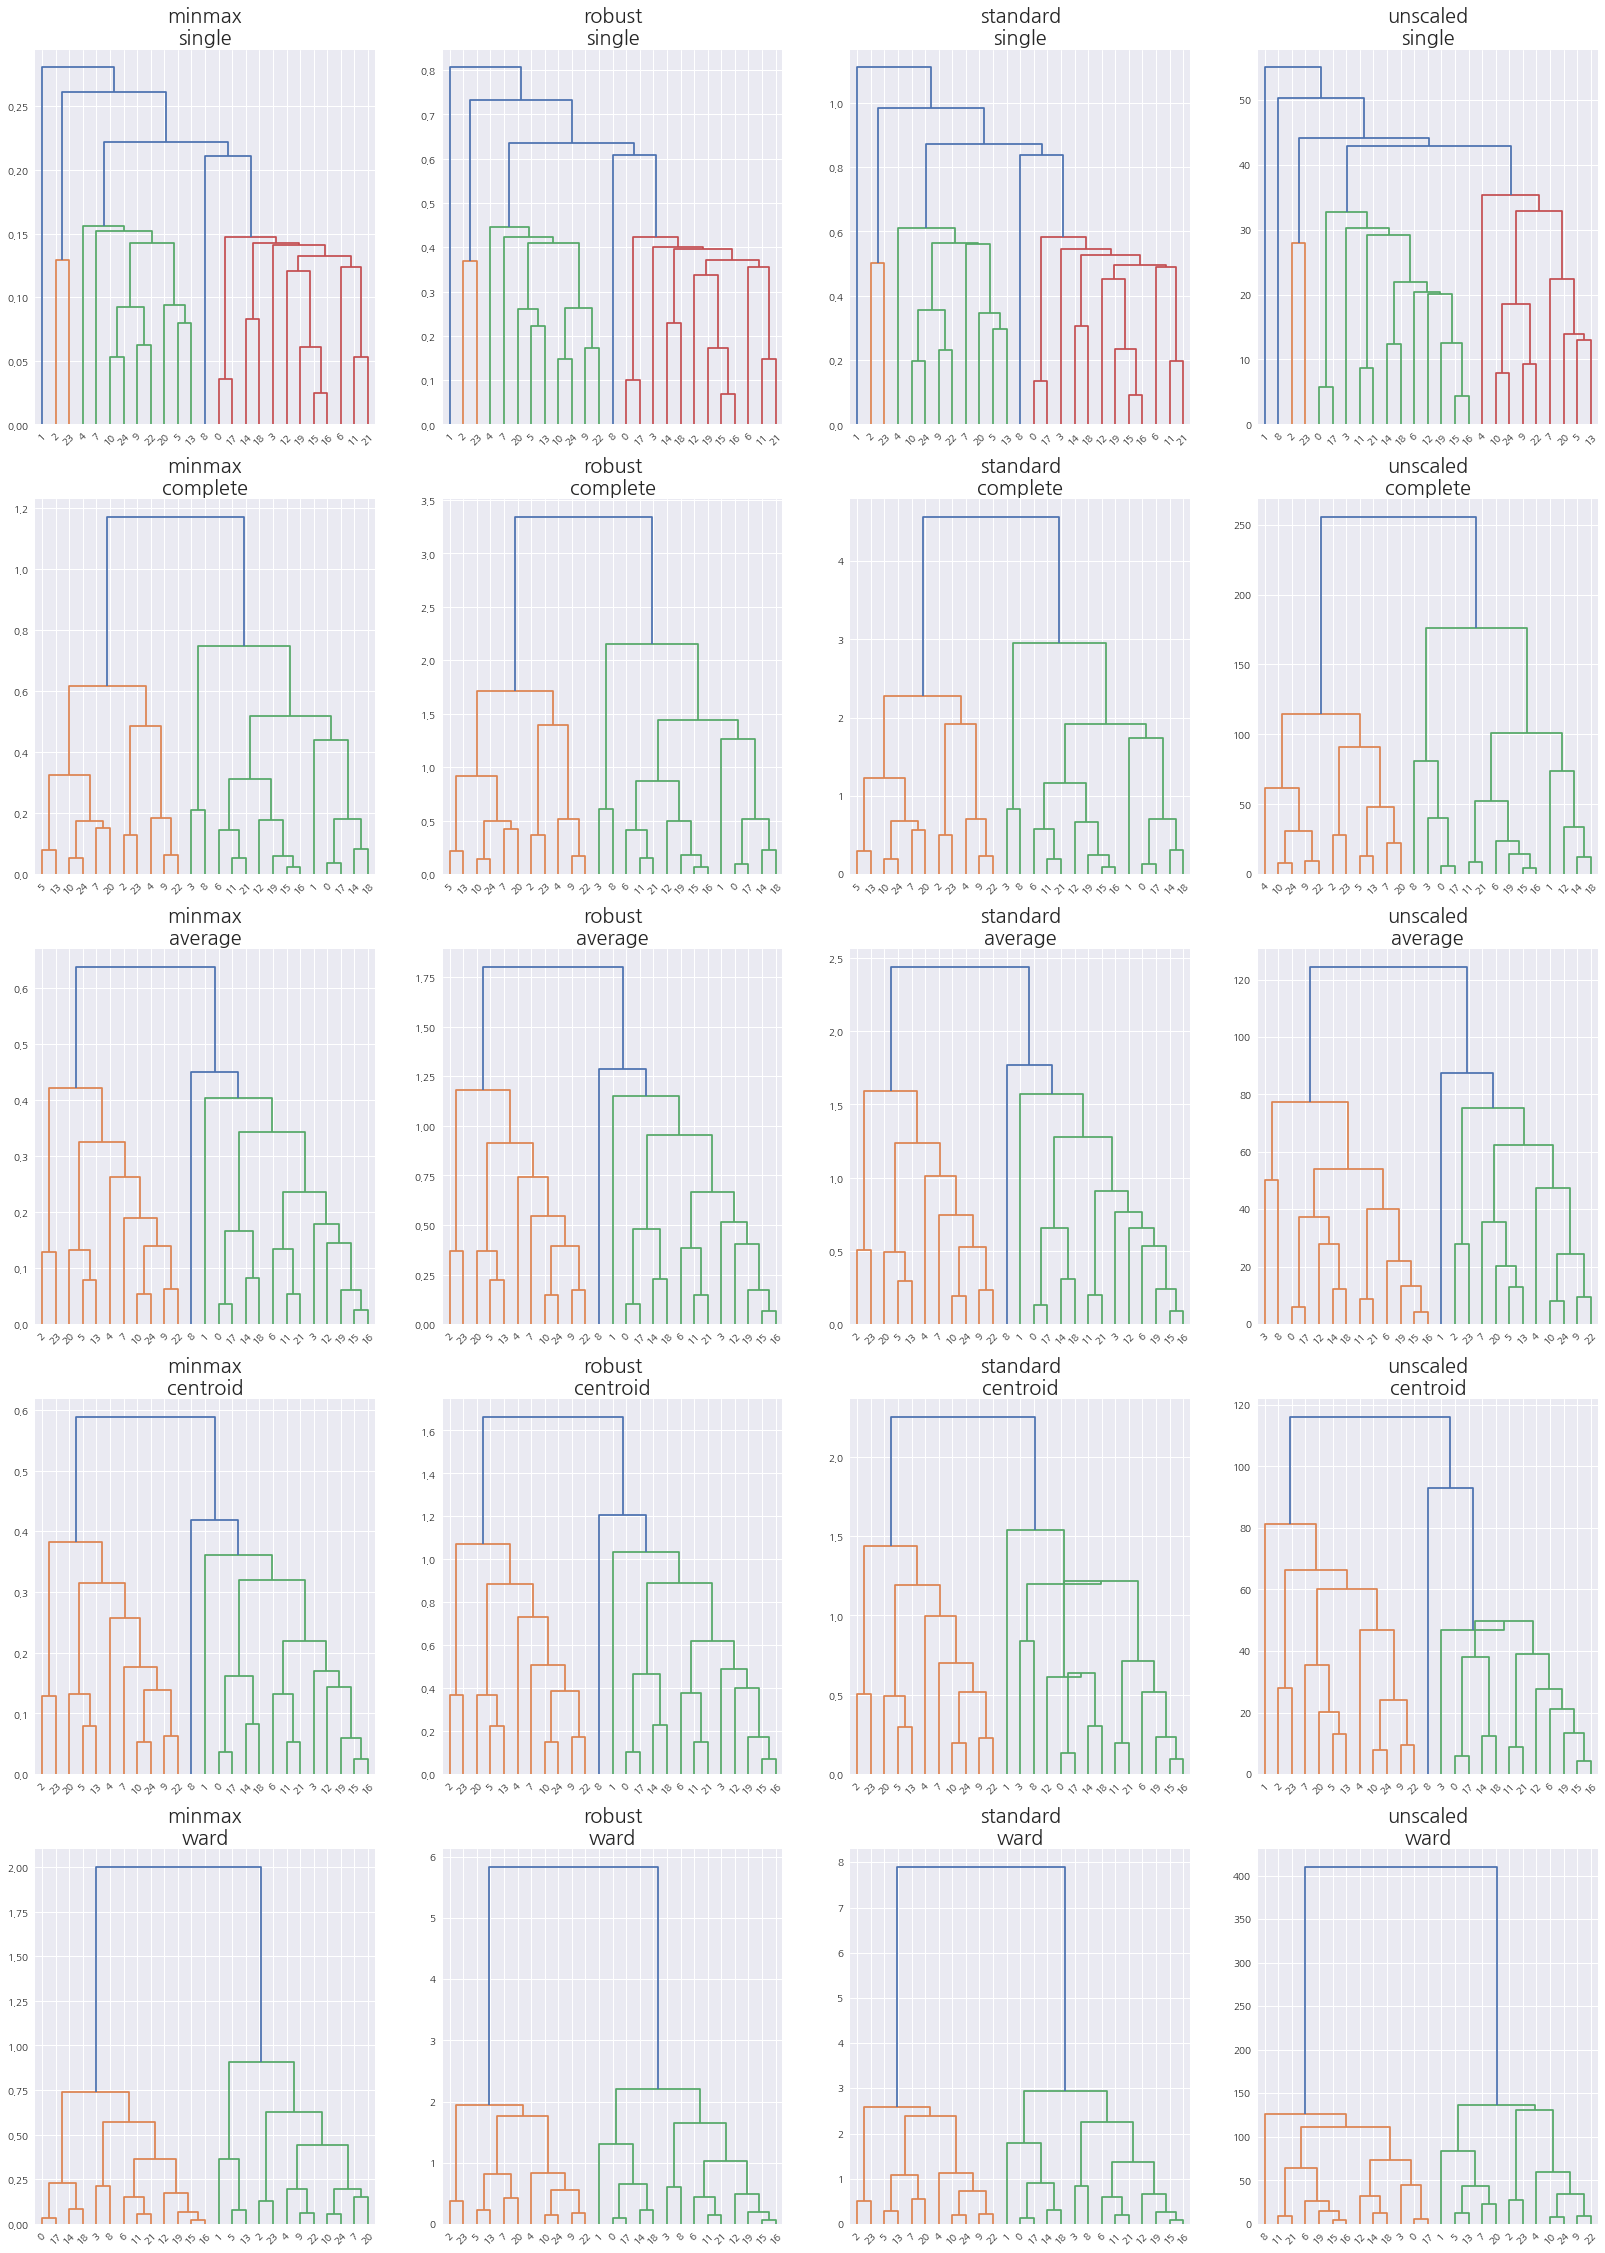

In [40]:
cols = ['노령화지수', '접근성']
cols_ = ['노령화지수', '접근성'] # 스케일링할 변수
scaler = ['minmax', 'robust', 'standard', 'unscaled']
box = {}

for m in scaler:
    if m == 'unscaled':
        box[m] = df.loc[:,cols]
    else:
        box[m] = df_scaler(df, cols_, scale = m) # scaling 함수 적용

n=len(box)

linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']

fig, axes = plt.subplots(nrows=len(linkage_list), ncols=n, figsize=(28, 40))
for i in range(len(linkage_list)):
    for j in range(len(scaler)):
        hierarchical_single = linkage(box[scaler[j]].loc[:,cols], method=linkage_list[i])
        dn = dendrogram(hierarchical_single, ax=axes[i][j])
        axes[i][j].set_title(f"{scaler[j]}\n{linkage_list[i]}", fontsize = 20)
        
        
plt.show()

거리 측정법별로 실루엣 계수가 가장 높을 때를 나타냄

## single

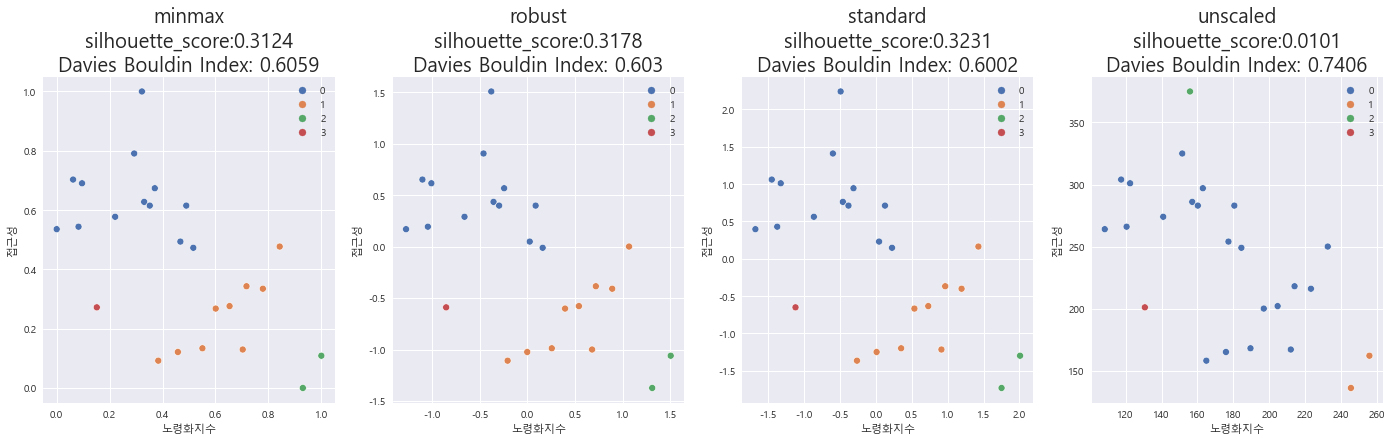

In [69]:
# Scatter Plot으로 군집화 시각화 확인
n = len(box)
fig, axes = plt.subplots(1,n,figsize = (6 * n, 6))

for i in range(len(scaler)):
    
    agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='single')
    labels = agg_clustering.fit_predict(box[scaler[i]].loc[:,cols])
    
    s=sns.scatterplot(x= cols[0], y=cols[1], data= box[scaler[i]], hue=labels, palette='deep', ax = axes[i], marker='o')
    s.set_title(f"{scaler[i]}\nsilhouette_score:{round(silhouette_score(box[scaler[i]].loc[:,cols], labels),4)}\nDavies Bouldin Index: {round(davies_bouldin_score(box[scaler[i]].loc[:,cols],labels),4)}", fontsize = 20)

plt.show()

## complete

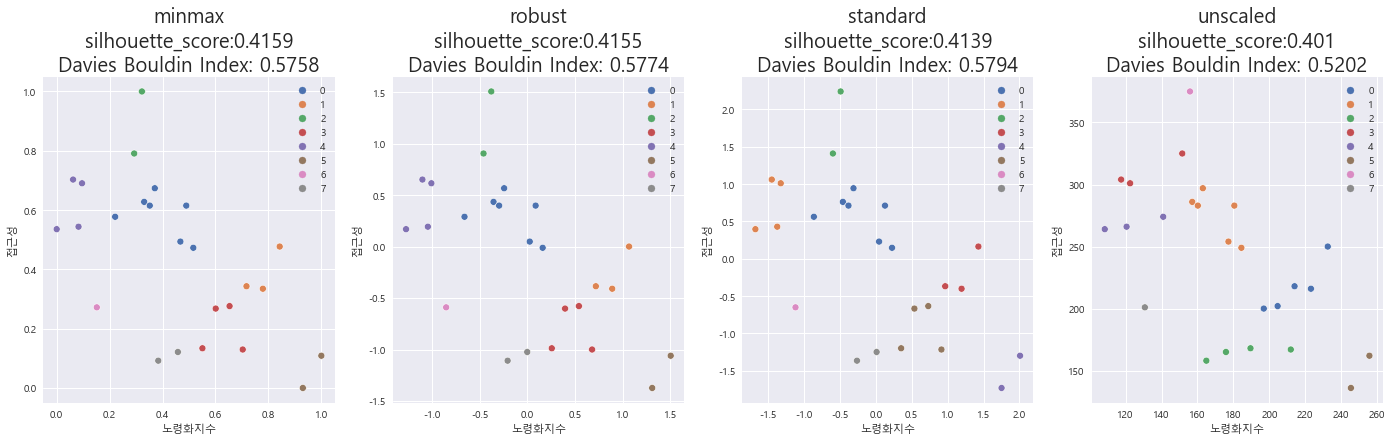

In [57]:
# Scatter Plot으로 군집화 시각화 확인
n = len(box)
fig, axes = plt.subplots(1,n,figsize = (6 * n, 6))

for i in range(len(scaler)):
    
    agg_clustering = AgglomerativeClustering(n_clusters=8, linkage='complete')
    labels = agg_clustering.fit_predict(box[scaler[i]].loc[:,cols])
    
    s=sns.scatterplot(x= cols[0], y=cols[1], data= box[scaler[i]], hue=labels, palette='deep', ax = axes[i], marker='o')
    s.set_title(f"{scaler[i]}\nsilhouette_score:{round(silhouette_score(box[scaler[i]].loc[:,cols], labels),4)}\nDavies Bouldin Index: {round(davies_bouldin_score(box[scaler[i]].loc[:,cols],labels),4)}", fontsize = 20)

plt.show()

## average

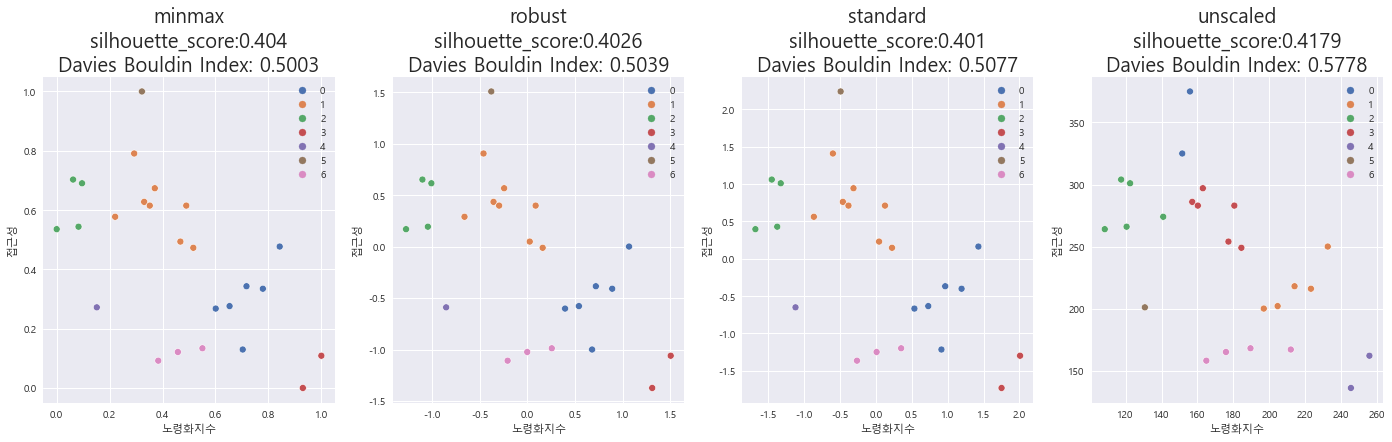

In [62]:
# Scatter Plot으로 군집화 시각화 확인
n = len(box)
fig, axes = plt.subplots(1,n,figsize = (6 * n, 6))

for i in range(len(scaler)):
    
    agg_clustering = AgglomerativeClustering(n_clusters=7, linkage='average')
    labels = agg_clustering.fit_predict(box[scaler[i]].loc[:,cols])
    
    s=sns.scatterplot(x= cols[0], y=cols[1], data= box[scaler[i]], hue=labels, palette='deep', ax = axes[i], marker='o')
    s.set_title(f"{scaler[i]}\nsilhouette_score:{round(silhouette_score(box[scaler[i]].loc[:,cols], labels),4)}\nDavies Bouldin Index: {round(davies_bouldin_score(box[scaler[i]].loc[:,cols],labels),4)}", fontsize = 20)

plt.show()

## ward

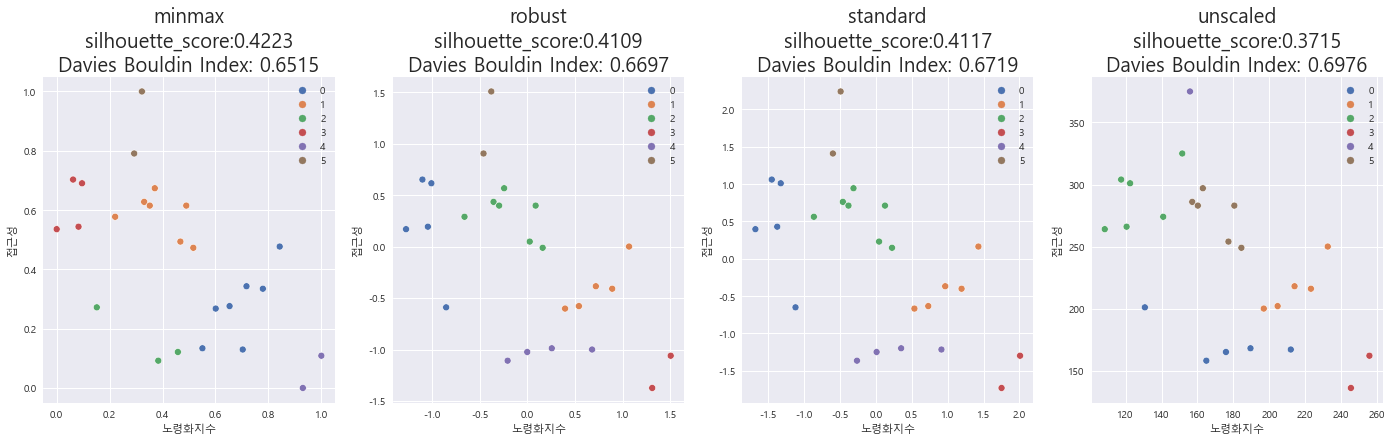

In [70]:
# Scatter Plot으로 군집화 시각화 확인
n = len(box)
fig, axes = plt.subplots(1,n,figsize = (6 * n, 6))

for i in range(len(scaler)):
    
    agg_clustering = AgglomerativeClustering(n_clusters=6, linkage='ward')
    labels = agg_clustering.fit_predict(box[scaler[i]].loc[:,cols])
    
    s=sns.scatterplot(x= cols[0], y=cols[1], data= box[scaler[i]], hue=labels, palette='deep', ax = axes[i], marker='o')
    s.set_title(f"{scaler[i]}\nsilhouette_score:{round(silhouette_score(box[scaler[i]].loc[:,cols], labels),4)}\nDavies Bouldin Index: {round(davies_bouldin_score(box[scaler[i]].loc[:,cols],labels),4)}", fontsize = 20)

plt.show()

## 군집 라벨 확인

ward 기법이 군집 수도 적당하고 군집을 잘 나눠주는 것으로 보임  
그 중 minmax의 실루엣계수가 가장 높아 해당 조건에 대한 군집 라벨을 살펴봄

In [76]:
agg_clustering = AgglomerativeClustering(n_clusters=6, linkage='ward')  # 'single', 'complete', 'average', 'centroid', 'ward'
labels = agg_clustering.fit_predict(box[scaler[0]].loc[:,cols])  # 0:'minmax', 1:'robust', 2:'standard', 3:'unscaled'
hc = df.copy()

hc['노령화지수'] = df_scaler(hc, cols=['노령화지수'], scale='minmax')['노령화지수']
hc['접근성'] = df_scaler(hc, cols=['접근성'], scale='minmax')['접근성']
hc['label'] = labels
hc.sort_values('label')

,CTY_NM,노령화지수,접근성,label
24,중랑구,0.653201,0.276151,0
22,종로구,0.779013,0.334728,0
20,용산구,0.550655,0.133891,0
4,관악구,0.842584,0.476987,0
7,금천구,0.702914,0.129707,0
9,도봉구,0.717129,0.343096,0
10,동대문구,0.600835,0.267782,0
21,은평구,0.516221,0.472803,1
19,영등포구,0.370636,0.673640,1
16,성북구,0.351690,0.615063,1
